In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
IMG_PATH = "data/cuboid-sphere.png"

In [3]:
img = cv2.imread(IMG_PATH, cv2.IMREAD_COLOR)

In [4]:
def imshow(cv_img):
    plt.figure(figsize=(20, 20)) 
    plt.imshow(cv2.cvtColor(cv_img, cv2.COLOR_BGR2RGB))

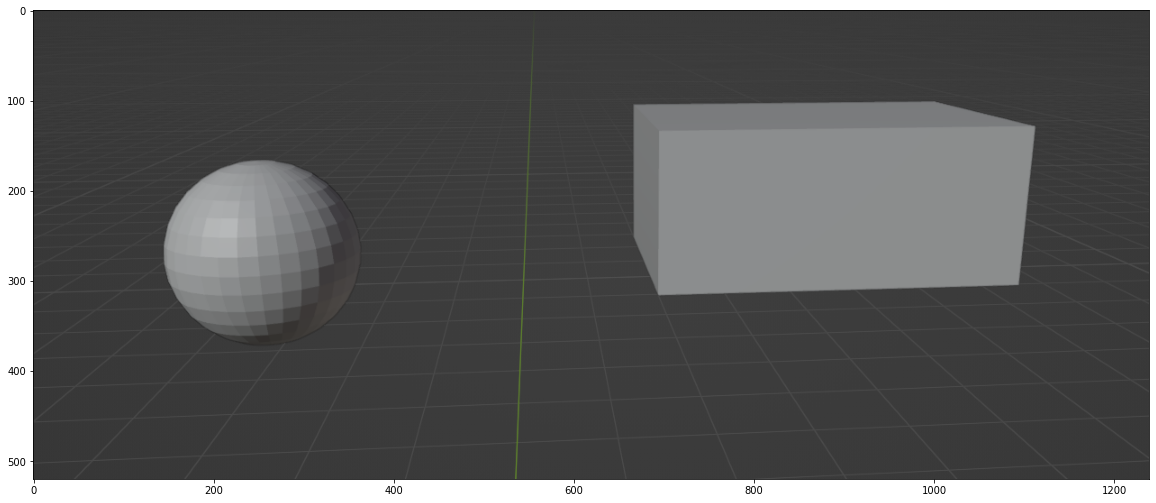

In [5]:
imshow(img)

## Task 2

In [6]:
def detect_circles(cv_img):
    gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
    return cv2.HoughCircles(
        image=gray,
        method=cv2.HOUGH_GRADIENT,
        dp=1,
        minDist=20,
        param1=100,
        param2=50,
        minRadius=0,
        maxRadius=0,
    )


def detect_cuboid_face(cv_img):
    gray = cv2.cvtColor(cv_img, cv2.COLOR_BGR2GRAY)
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    plt.hist(gray)
    face_brightness = np.argmax(hist.flatten())
    ret, thresh1 = cv2.threshold(gray, int(2.1 * face_brightness), 1, cv2.THRESH_BINARY)
    print(hist.shape)
    print(face_brightness)
    return thresh1.astype(np.float32)


def draw_circles(cv_img, circles):
    assert isinstance(circles, np.ndarray)
    out = np.copy(cv_img)
    circles = circles[0].astype(np.int32)
    for cx, cy, rad in circles:
        cv2.circle(out, (cx, cy), rad, (0, 255, 0), 2)
    return out



(256, 1)
60


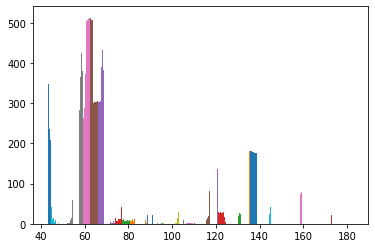

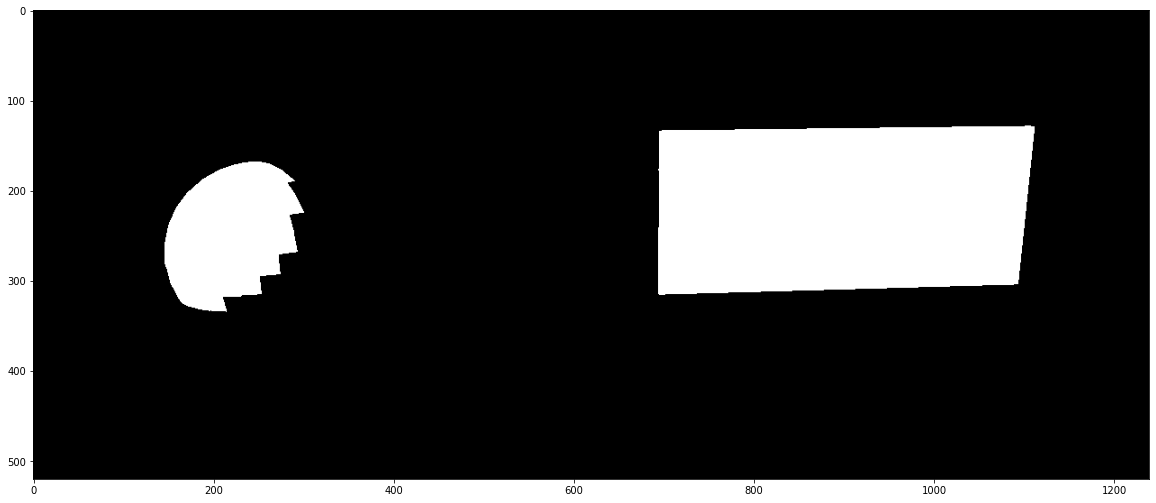

In [7]:
imshow(detect_cuboid_face(img))

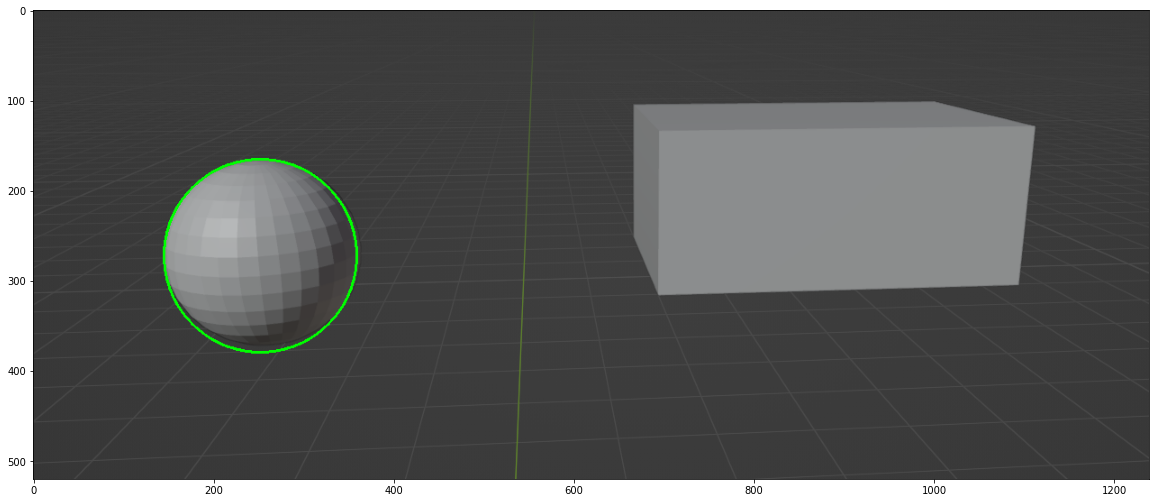

In [8]:
circles = detect_circles(img)
vis_img = draw_circles(img, circles)
imshow(vis_img)

## Task 1

In [9]:
import h5py

CLOUD_PATH = "data/cuboid-sphere.hdf5"
f = h5py.File(CLOUD_PATH, 'r')

In [10]:
list(f.keys())

['depth_map', 'intensity_map']

In [11]:
depth_map_dataset = f["depth_map"]
depth_map = np.asarray(depth_map_dataset)
attrs = depth_map_dataset.attrs
fov = attrs["vertical_fov_deg"], attrs["horizontal_fov_deg"]
intensity_map = np.asarray(f["intensity_map"])
mask = np.logical_not(np.isnan(depth_map))

In [12]:
depth_map[mask].max(), depth_map[mask].min()

(11.101564519514298, 8.449404218084263)

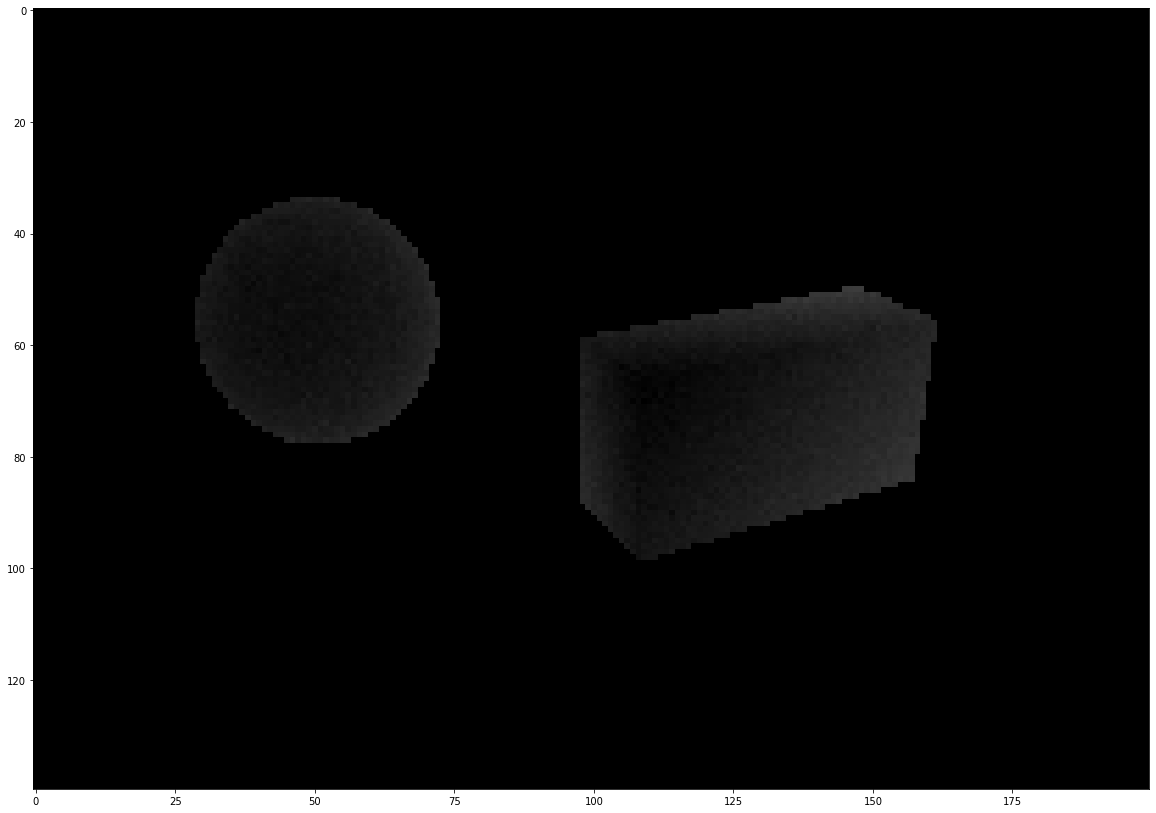

In [13]:
norm_map = (depth_map - depth_map[mask].min()) / depth_map[mask].max()

imshow(np.nan_to_num(norm_map, 0).astype(np.float32))

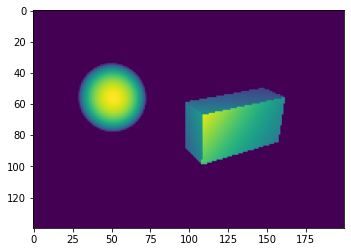

In [14]:
plt.imshow(intensity_map)

In [20]:
def get_uniform_median(size):
    if size % 2:
        return size // 2
    else:
        return size / 2 + 0.5
    

def normalize_vector(v):
    v = np.asarray(v, dtype=np.float32)
    norm = np.linalg.norm(v)
    assert not np.isclose(np.abs(norm), 0.)
    return v / norm


def rotation_angle(vec1, vec2):
    vec1 = normalize_vector(vec1)
    vec2 = normalize_vector(vec2)
    return np.arcsin(
        np.linalg.norm(
            np.cross(vec1, vec2)
        )
    )


def rot_mat_x(angle):
    return np.asarray([
        [1, 0, 0],
        [0, np.cos(angle), -np.sin(angle)],
        [0, np.sin(angle), np.cos(angle)],
    ])


def rot_mat_y(angle):
    return np.asarray([
        [np.cos(angle), 0, np.sin(angle)],
        [0, 1., 0],
        [-np.sin(angle), 0, np.cos(angle)],
    ])


def compute_cam2world_transform(cam_axis_xyz, translation_xyz=None):
    if translation_xyz is None:
        translation_xyz = [0, 0, 0]
    x, y, z = normalize_vector(cam_axis_xyz)
    
    x_rot = rotation_angle([0, 0, 1], [0, y, z]) * np.sign(y)
    y_rot = rotation_angle([0, y, z], [x, y, z]) * np.sign(-x)    
    rot_mat = np.dot(rot_mat_y(x_rot), rot_mat_x(y_rot))
    
    transform = np.zeros(shape=(4, 4), dtype=np.float32)
    transform[:3, :3] = rot_mat
    transform[0, 3] = translation_xyz[0]
    transform[1, 3] = translation_xyz[1]
    transform[2, 3] = translation_xyz[2]
    transform[3, 3] = 1
    
    return transform


def apply_transform(xyz, transform):
    points_cnt = xyz.shape[0]   
    xyz_homog = np.hstack([xyz, np.ones(shape=[points_cnt, 1])])
    return np.dot(transform, xyz_homog.T).T[:, :-1]  


def compute_cloud(depth_map, intensity_map, fov, cam_axis):
    mask = np.logical_not(np.isnan(depth_map))
    map_shape = depth_map.shape
    pixel_angles = np.asarray(fov) / np.asarray(map_shape)
    pixel_angles = np.radians(pixel_angles)
    
    y_idx, x_idx =  np.indices(map_shape, dtype=np.float32)
    y_offset, x_offset = get_uniform_median(map_shape[0]), get_uniform_median(map_shape[1])
    
    y_idx = (y_idx - y_offset) * pixel_angles[0]
    x_idx = (x_idx - x_offset) * pixel_angles[1]
    
    xyzi = np.stack([x_idx, y_idx, depth_map, intensity_map], axis=0)
    xyzi = np.transpose(xyzi, [1, 2, 0])
    
    xyzi = xyzi[mask]
    
    z = xyzi[:, 2]
    xyzi[:, 0] = z * np.tan(xyzi[:, 0])
    xyzi[:, 1] = z * np.tan(xyzi[:, 1])
    
    cam2world = compute_cam2world_transform(cam_axis)   
    xyzi[:, :3] = apply_transform(xyzi[:, :3], cam2world)
    
    return xyzi

In [21]:
cloud = compute_cloud(depth_map, intensity_map, fov, [0.5, 0.5, 1])

In [22]:
cloud.shape

(3878, 4)

In [185]:
%matplotlib widget


def visualize_cloud(cloud, color="red"):
    fig = plt.figure(figsize=(10, 6)) 
    ax = fig.add_subplot(111, projection='3d') 
    ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=color, alpha=0.5, s=0.25) 

    x_min, x_max = np.min(cloud[:, 0]), np.max(cloud[:, 0])
    xc = 0.5 * (x_max + x_min)
    y_min, y_max = np.min(cloud[:, 1]), np.max(cloud[:, 1])
    yc = 0.5 * (y_max + y_min)
    z_min, z_max = np.min(cloud[:, 2]), np.max(cloud[:, 2])
    zc = 0.5 * (z_max + z_min)

    vis_cube_half_side = max(
        (x_max - x_min),
        (y_max - y_min),
        (z_max - z_min),
    ) * 1.2 / 2

    ax.set_xlim([xc - vis_cube_half_side, xc + vis_cube_half_side])
    ax.set_ylim([yc - vis_cube_half_side, yc + vis_cube_half_side])
    ax.set_zlim([zc - vis_cube_half_side, zc + vis_cube_half_side])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
    

def visualize_clouds(clouds, colors):
    fig = plt.figure(figsize=(10, 6)) 
    ax = fig.add_subplot(111, projection='3d')
    
    for cloud, color in zip(clouds, colors):
        ax.scatter(cloud[:, 0], cloud[:, 1], cloud[:, 2], c=color, alpha=0.5, s=0.25) 
        
    merged_cloud = np.vstack(clouds)

    x_min, x_max = np.min(merged_cloud[:, 0]), np.max(merged_cloud[:, 0])
    xc = 0.5 * (x_max + x_min)
    y_min, y_max = np.min(merged_cloud[:, 1]), np.max(merged_cloud[:, 1])
    yc = 0.5 * (y_max + y_min)
    z_min, z_max = np.min(merged_cloud[:, 2]), np.max(merged_cloud[:, 2])
    zc = 0.5 * (z_max + z_min)

    vis_cube_half_side = max(
        (x_max - x_min),
        (y_max - y_min),
        (z_max - z_min),
    ) * 1.2 / 2

    ax.set_xlim([xc - vis_cube_half_side, xc + vis_cube_half_side])
    ax.set_ylim([yc - vis_cube_half_side, yc + vis_cube_half_side])
    ax.set_zlim([zc - vis_cube_half_side, zc + vis_cube_half_side])

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()
        

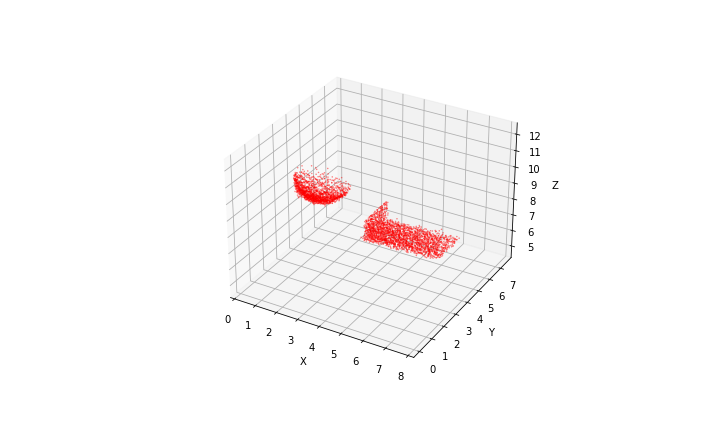

In [186]:
visualize_cloud(cloud)

In [187]:
from sklearn.cluster import KMeans


def clusterize_cloud(cloud, clusters=2):
    assert cloud.shape[1] >= 4
    coords = cloud[:, :3]
    clusterizer = KMeans(n_clusters=clusters, random_state=0)
    clusterizer.fit(coords)
    
    output = []
    for cluster_id in range(clusters):
        mask = clusterizer.labels_ == cluster_id
        output.append(cloud[mask])
    
    return output

In [188]:
objects = clusterize_cloud(cloud)

In [189]:
len(objects)

2

In [190]:
import numpy as np
import math
"""
lstsq_sphere_fitting: fit a given set of 3D points (x, y, z) to a sphere.
Args:
   pos_xyz: a two dimentional numpy array, of which each row represents (x, y, z) coordinates of a point
Returns:
   radius, x0, y0, z0
"""
def lstsq_sphere_fitting(pos_xyz):
    # add column of ones to pos_xyz to construct matrix A
    row_num = pos_xyz.shape[0]
    A = np.ones((row_num, 4))
    A[:,0:3] = pos_xyz

    # construct vector f
    f = np.sum(np.multiply(pos_xyz, pos_xyz), axis=1)
    
    sol, residules, rank, singval = np.linalg.lstsq(A,f)

    # solve the radius
    radius = math.sqrt((sol[0]*sol[0]/4.0)+(sol[1]*sol[1]/4.0)+(sol[2]*sol[2]/4.0)+sol[3])

    return sol[0]/2.0, sol[1]/2.0, sol[2]/2.0, radius

In [191]:
sphere = objects[1][:, :3]
lstsq_sphere_fitting(sphere)

/tmp/ipykernel_21177/3060877234.py:19: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  sol, residules, rank, singval = np.linalg.lstsq(A,f)


(1.8436836056453323, 3.445159076504095, 9.735117099455351, 1.084387109726285)

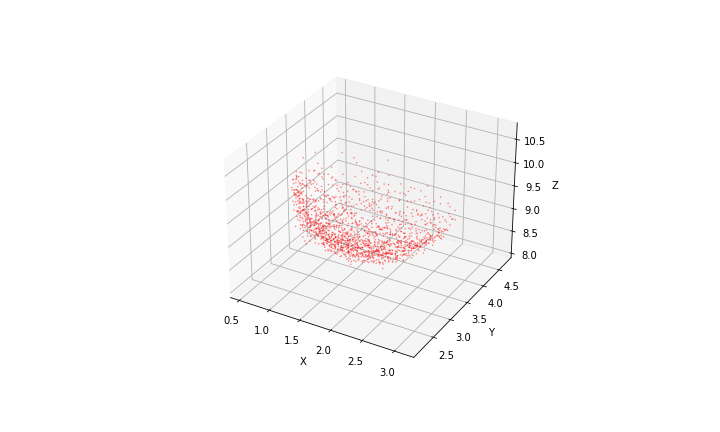

In [192]:
visualize_cloud(objects[1])

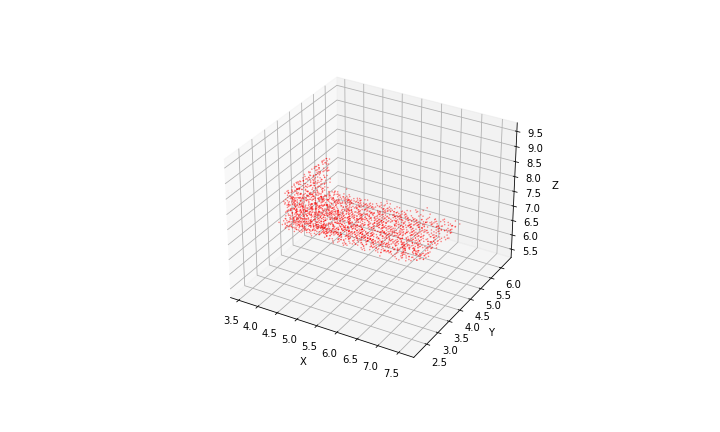

In [193]:
cuboid = objects[0][:, :3]
visualize_cloud(objects[0])

In [250]:
import open3d as o3d


def segment_cuboid(cloud, expected_faces=3, dist_thresh=0.15):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cloud)
    
    output_equations = []
    segments = []
    for i in range(expected_faces):
        plane_model, inliers = pcd.segment_plane(
            distance_threshold=dist_thresh, ransac_n=3, num_iterations=100)
        output_equations.append(plane_model)
        inlier_cloud = pcd.select_by_index(inliers)
        segments.append(np.asarray(inlier_cloud.points))
        pcd = pcd.select_by_index(inliers, invert=True)
    
    return output_equations, segments

In [251]:
def dummy_classifier(cloud):
    total_points = len(cloud)
    _, segments = segment_cuboid(cloud, dist_thresh=0.05)
    segmented_points = sum([len(x) for x in segments])
    segmented_share = segmented_points / total_points
    return segmented_share > 0.5, segmented_share


for i in range(100):
    c, p = dummy_classifier(cuboid)
    print(f"Cuboid. OK: {c==True}\t {c} {p}")
    c, p = dummy_classifier(sphere)
    print(f"Sphere. OK: {c==False}\t {c} {p}")

Cuboid. OK: True	 True 0.6559048428207307
Sphere. OK: True	 False 0.3746719160104987
Cuboid. OK: True	 True 0.6469838572642311
Sphere. OK: True	 False 0.38713910761154857
Cuboid. OK: True	 True 0.6482582837723024
Sphere. OK: True	 False 0.3779527559055118
Cuboid. OK: True	 True 0.7060322854715378
Sphere. OK: True	 False 0.39173228346456695
Cuboid. OK: True	 True 0.6677994902293968
Sphere. OK: True	 False 0.3799212598425197
Cuboid. OK: True	 True 0.7009345794392523
Sphere. OK: True	 False 0.38188976377952755
Cuboid. OK: True	 True 0.6890399320305862
Sphere. OK: True	 False 0.38320209973753283
Cuboid. OK: True	 True 0.6682242990654206
Sphere. OK: True	 False 0.40091863517060367
Cuboid. OK: True	 True 0.6580288870008496
Sphere. OK: True	 False 0.37926509186351703
Cuboid. OK: True	 True 0.6796941376380629
Sphere. OK: True	 False 0.38910761154855644
Cuboid. OK: True	 True 0.6601529311809685
Sphere. OK: True	 False 0.3779527559055118
Cuboid. OK: True	 True 0.7026338147833475
Sphere. OK: True

In [252]:
planes, segments = segment_cuboid(cuboid)

In [253]:
len(segments)

3

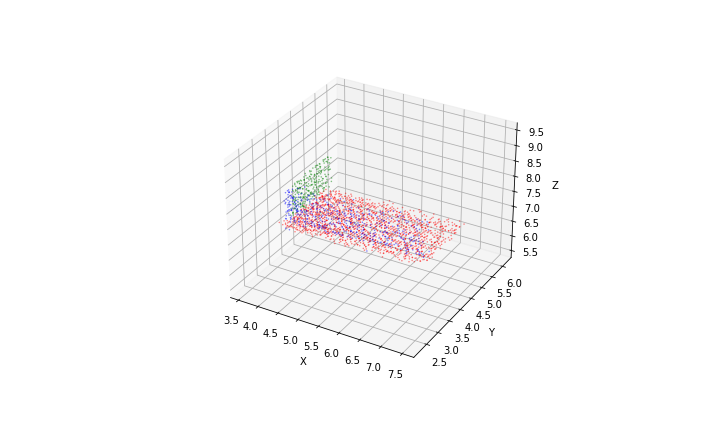

In [257]:
visualize_clouds(segments, ["red", "blue", "green"])

In [258]:
len(cuboid), len(segments[0]) + len(segments[1]) + len(segments[2])

(2354, 2322)

In [283]:
def compute_cube_geometry(cuboid):
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(cuboid)
    obb = pcd.get_oriented_bounding_box()
    whl = obb.extent
    xyz = obb.center
    return np.asarray(xyz), np.asarray(whl)

In [284]:
compute_cube_geometry(cuboid)

(array([5.55214461, 4.14655857, 7.2949098 ]),
 array([3.63383781, 2.24347709, 1.82343877]))